# Multi-Agent Content Development Team using LangGraph

Heyooo! I'm back.

Don´t know if you all read my first blog post about **LangGraph**, If you didn’t and want to check out some basics, here it is: [What is LangGraph and Can It Help You Build LLM Agents?](link)!

Anyways, today we are gonna dive a little deeper into **LangGraph**. I'll try to show you how to build a simple but usefull multi-agent team. While doing that, we are going to revisit some concepts to better understand how everything works, where things come from, and where they are going, as LangGraph can be a little tricky for newcomers.

### What is Lan...

"This again?" One might ask. Yeah, bear with me, let's fix this concept once and for all!

## What is LangGraph?

Well, as I was saying, **LangGraph** is an extension of **LangChain**, whose main objective is creating agent and multi-agent projects. It adds the ability to create cyclical flows while providing developers a high degree of control, which is - obviously - very important for creating custom agents and flows.

I think that's enough theoretical jibber jabber for now. Let's start building something!

## Building the - not the best - but pretty good Content Development Team

With this project, I want to show you all that we can improve almost any process in depth and quality by leveraging multiple agents with specialized skills. Why is that? Well, having every agent focus and specialize only in a specific task allows more customizability, better separation of concerns, and, of course, further development as the project grows. LangGraph is no place for a jack of all trades.

## The Content Development Team

Our humble team consists of three agents:

* **Researcher** - This fella is specialized in web search. He will deliver in-depth research on a given topic. No questions asked.
* **Editor** - The role of this agent is to be annoying with his buddy the researcher. The editor will review the content brought by the researcher agent and demand more whenever he thinks it's needed. He will also provide some query tips.
* **Writer** - This is the last agent of our flow, responsible for writing about the suggested topic using the context available from the previously mentioned agents.

#### As promised, we will now dive into the code!!

## Setup

As always, first we need to install the required packages

In [1]:
%%capture --no-stderr
%pip install -U langgraph langsmith

# Used for this tutorial; not a requirement for LangGraph
%pip install -U langchain_openai

Next, let's set the API key for OpenAI

In [2]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

OpenAI API Key:········


Also, let's set up our [LangSmith](https://www.langchain.com/langsmith) key as it makes it a lot easier to see what's going on under the hood (optional, but encouraged).

In [3]:
os.environ["LANGSMITH_API_KEY"] = getpass.getpass("LangSmith API Key:")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-Agent Tutorial"

LangSmith API Key:········


We'll be using the [Tavily Search Engine](https://python.langchain.com/v0.1/docs/integrations/tools/tavily_search/). **It's super easy to register and they offer a free tier.** (Feel fre to check [GPT Researcher](https://gptr.dev/) aswel!)

In [4]:
os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API Key:")

Tavily API Key:········


## Define the State

Now this is an awesome feature from LangGraph that I absolutely love: state management. States in LangGraph are facilitated through a structured approach where developers define a GraphState that encapsulates the entire state of the application. Each node in the graph can modify this state, allowing for dynamic responses based on the evolving context of the interaction.

If you've worked with data, you know the data schema is always a key point that you just can't take for granted, even in a simple project like this one. Check ours out:

In [5]:
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from typing import Annotated


class State(TypedDict):
    query: Annotated[list, add_messages]
    research: Annotated[list, add_messages]
    content: str
    content_ready: bool
    iteration_count: int  # Counter for iterations

# Initialize the StateGraph
graph = StateGraph(State)

## Introducing Our Multi-Agent Team

Let's dive into the team we were talking about: our one and only **Content Development Team**. Our team is made up of three specialized agents, each with a distinct role to ensure high-quality content development.

### Research Agent

First up, we have the Research Agent. This agent is responsible for conducting in-depth web searches to gather valuable information on a given topic.

In [6]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI

# Initialize ChatOpenAI instance for language model
llm = ChatOpenAI(openai_api_key=os.environ["OPENAI_API_KEY"], model="gpt-3.5-turbo", temperature=0)


class ResearchAgent:
    def __init__(self):
        pass
    
    def format_search(self, query: str) -> str:
        # Prepare prompt for the language model to optimize the search query
        # Using Few-Shot Prompting to ensure we receive only the optimized query
        prompt = (
            "You are an expert at optimizing search queries for Google. "
            "Your task is to take a given query and return an optimized version of it, making it more likely to yield relevant results. "
            "Do not include any explanations or extra text, only the optimized query.\n\n"
            "Example:\n"
            "Original: best laptop 2023 for programming\n"
            "Optimized: top laptops 2023 for coding\n\n"
            "Example:\n"
            "Original: how to train a puppy not to bite\n"
            "Optimized: puppy training tips to prevent biting\n\n"
            "Now optimize the following query:\n"
            f"Original: {query}\n"
            "Optimized:"
        )
        
        # Invoke language model to optimize query
        response = llm.invoke(prompt)
        return response.content
    
    def search(self, state: State):
        # Initialize TavilySearchResults instance to perform the web search
        search = TavilySearchResults(max_results=1)
        # Get the latest query from the state and optimize it using the format_search method
        optimized_query = self.format_search(state.get('query', "")[-1].content)
        # Perform the search using the optimized query
        results = search.invoke(optimized_query)
        # Return only the content from the research results
        return {"research": [results[0]["content"]]}

### Editor Agent

The Editor Agent is responsible for evaluating the research provided by the Research Agent. This agent checks if the research content is sufficient for creating a comprehensive and accurate blog post. If the content is insufficient, it suggests new queries to improve the research results.

In [7]:
class EditorAgent:
    def __init__(self):
        pass
    
    def evaluate_research(self, state: State):
        # Combine all queries into a single string
        query = '\n'.join(message.content for message in state.get("query"))
        print(f"Query/queries: {query}")
        print("-"*20)
        
        # Combine all research content into a single string
        research = '\n'.join(message.content for message in state.get("research"))
        print(f"Research Content: {research}")
        print("-"*20)
        
        # Get the current iteration count, defaulting to 1 if not set
        iteration_count = state.get("iteration_count", 1)
        
        # Ensure iteration_count is always an integer
        if iteration_count is None:
            iteration_count = 1
        
        print(f"Iteration n.: {iteration_count}")
        print("-"*20)
        
        # Limit to 3 iterations to avoid infinite loops
        if iteration_count >= 3:
            return {"content_ready": True}
        
        # Prepare the prompt for the language model to evaluate the research
        prompt = (
            "You are an expert editor. Your task is to evaluate the research based on the query. "
            "If the information is sufficient to create a comprehensive and accurate blog post, respond with 'sufficient'. "
            "If the information is not sufficient, respond with 'insufficient' and provide a new, creative query suggestion to improve the results. "
            "If the research results appear repetitive or not diverse enough, think about a very different kind of question that could yield more varied and relevant information. "
            "Consider the depth, relevance, and completeness of the information when making your decision.\n\n"
            "Example 1:\n"
            "Used queries: What are the benefits of a Mediterranean diet?\n"
            "Research: The Mediterranean diet includes fruits, vegetables, whole grains, and healthy fats.\n"
            "Evaluation: Insufficient\n"
            "New query: Detailed health benefits of a Mediterranean diet\n\n"
            "Example 2:\n"
            "Used queries: How does solar power work?\n"
            "Research: Solar power works by converting sunlight into electricity using photovoltaic cells.\n"
            "Evaluation: Sufficient\n\n"
            "Example 3:\n"
            "Used queries: Effects of climate change on polar bears?\n"
            "Research: Climate change is reducing sea ice, affecting polar bear habitats.\n"
            "Evaluation: Insufficient\n"
            "New query: How are polar bears adapting to the loss of sea ice due to climate change?\n\n"
            "Now evaluate the following:\n"
            f"Used queries: {query}\n"
            f"Research: {research}\n\n"
            "Evaluation (sufficient/insufficient):\n"
            "New query (if insufficient):"
        )
        
        # Invoke the language model with the prompt
        response = llm.invoke(prompt)
        evaluation = response.content.strip()
        
        # Display the evaluation result for debugging purposes
        print(f"Eval: {evaluation}")
        print("-"*20)
        
        # Check if a new query is suggested in the evaluation
        if "new query:" in evaluation.lower():
            new_query = evaluation.split("New query:", 1)[-1].strip()
            return {"query": [new_query], "iteration_count": iteration_count + 1}
        else:
            return {"content_ready": True}


### Writer Agent

The Writer Agent is responsible for taking the optimized query and research content provided by the other agents to craft a well-written, engaging, and informative blog post. This agent ensures that the final content is comprehensive and easy to read.

In [8]:
class WriterAgent:
    def __init__(self):
        pass
    
    def write_blogpost(self, state: State):
        # Extract the original query from the state
        query = state.get("query")[0].content
        # Combine all research content into a single string
        research = '\n'.join(message.content for message in state.get("research"))
        
        # Prepare the prompt for the language model to write the blog post
        prompt = (
            "You are an expert blog post writer. Your task is to take a given query and context, and write a comprehensive, engaging, and informative short blog post about it. "
            "Make sure to include an introduction, main body with detailed information, and a conclusion. Use a friendly and accessible tone, and ensure the content is well-structured and easy to read.\n\n"
            f"Query: {query}\n\n"
            f"Context:\n{research}\n\n"
            "Write a detailed and engaging blog post based on the above query and context."
        )
        
        # Invoke the language model with the prompt to generate the blog post
        response = llm.invoke(prompt)
        
        # Return the generated content
        return {"content": response.content}

### Creating the Graph

Creating the LangGraph graph is very straightforward and consists of three main functions: `add_node`, `add_edge`, and `set_entry_point`. With these main functions, you can first add the nodes to the graph, connect the edges, and finally set the starting point. Let's break down the steps with comments to make it easy to follow.

In [9]:
from langgraph.graph import END

# Define nodes: Adding each agent to the graph as a node
# "search_agent" uses the search method of the ResearchAgent
# "writer_agent" uses the write_blogpost method of the WriterAgent
# "editor_agent" uses the evaluate_research method of the EditorAgent
graph.add_node("search_agent", ResearchAgent().search)
graph.add_node("writer_agent", WriterAgent().write_blogpost)
graph.add_node("editor_agent", EditorAgent().evaluate_research)

# Set entry point: The graph starts with the search_agent node
graph.set_entry_point("search_agent")

# Define edges: Connect the nodes in the order they should be executed
# After search_agent finishes, editor_agent is triggered
graph.add_edge("search_agent", "editor_agent")

# Define conditional edges for the editor agent
# Depending on the evaluation result, either proceed to writer_agent or go back to search_agent for revision
graph.add_conditional_edges(
    "editor_agent",
    lambda state: "accept" if state.get("content_ready") else "revise",
    {
        "accept": "writer_agent", # If content is ready, proceed to writer_agent
        "revise": "search_agent" # If content is not ready, go back to search_agent
    }
)

# Define edge to end the graph once the writer_agent is done
graph.add_edge("writer_agent", END)

# Compile the graph to finalize its structure
graph = graph.compile()

### Visualizing the Graph

To help visualize the structure of our LangGraph, we can use the `IPython.display` module to display the graph. This visualization shows how the agents are connected and how the flow proceeds from start to end, including conditional paths.

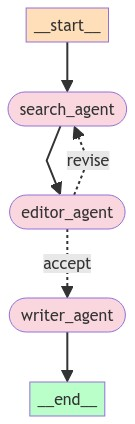

In [10]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### Running the Graph

Now that we've created and visualized our graph, it's time to see it in action. By invoking the graph with an initial query, we can start the multi-agent process and see the results.

Let's initiate the process with a sample query "Langchain vs. LangGraph".

In [15]:
blogpost = graph.invoke({"query":"What are the differences between LangChain and LangGraph?"})

Query/queries: What are the differences between LangChain and LangGraph?
--------------------
Research Content: 1. L angGraph is a library for building stateful, multi-actor applications with LLMs. It extends the LangChain Expression Language with the ability to coordinate multiple chains (or actors) across ...
--------------------
Iteration n.: 1
--------------------
Eval: Insufficient
New query: What are the key features and use cases of LangChain and LangGraph in the context of blockchain technology?
--------------------
Query/queries: What are the differences between LangChain and LangGraph?
What are the key features and use cases of LangChain and LangGraph in the context of blockchain technology?
--------------------
Research Content: 1. L angGraph is a library for building stateful, multi-actor applications with LLMs. It extends the LangChain Expression Language with the ability to coordinate multiple chains (or actors) across ...
🗃️ Tool use. 6 items. 📄️ Interacting with APIs. L

In [16]:
print(blogpost['content'])

In the world of language models and AI applications, two key tools have been making waves: LangChain and LangGraph. While both are designed to enhance the capabilities of large language models (LLMs), they serve different purposes and offer unique features. Let's dive into the differences between LangChain and LangGraph to understand how they can benefit developers and users alike.

LangGraph is a powerful library that focuses on building stateful, multi-actor applications with LLMs. It extends the LangChain Expression Language to enable the coordination of multiple chains or actors across various tasks. This means that developers can create complex applications that involve multiple actors working together, making it ideal for scenarios where collaboration and coordination are essential.

On the other hand, LangChain is a comprehensive framework that aims to streamline the development, productionization, and deployment of applications powered by LLMs. It acts as a bridge between the r